**Analysis on 120 years of Olympic history: athletes and results**

# Datasets

The core datasets used for this task were taken from Kaggle (https://www.kaggle.com/heesoo37/120-years-of-olympic-history-athletes-and-results).

This is a well-analysed dataset with over 100 kernels pinned against it on Kaggle. 

To enrich our analysis, and make it original, we also scraped some other datasets:

+ Using a dataset of capital city Latitude & Longitudes from Techslides.
+ Creating a new dataset of olympic host city Altitudes, Latitudes & Longitudes from mapcoordinates.

**Reference**

https://towardsdatascience.com/exploratory-statistical-data-analysis-with-a-real-dataset-using-pandas-208007798b92

https://ambim.github.io/Project-Notebook-(Olympics)/

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as  plt
import seaborn as sns
import unittest

from geopy.distance import vincenty, geodesic

%pylab inline
%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


## Load input corpus

In [2]:
dir_data_path = "./data/"
file_athlete_events_path = os.path.join(dir_data_path, "athlete_events.csv")

data = pd.read_csv(file_athlete_events_path, index_col = 'ID')
data.head(3)

Name Sex   Age  Height  Weight     Team  NOC        Games  \
ID                                                                             
1             A Dijiang   M  24.0   180.0    80.0    China  CHN  1992 Summer   
2              A Lamusi   M  23.0   170.0    60.0    China  CHN  2012 Summer   
3   Gunnar Nielsen Aaby   M  24.0     NaN     NaN  Denmark  DEN  1920 Summer   

    Year  Season       City       Sport                         Event Medal  
ID                                                                           
1   1992  Summer  Barcelona  Basketball   Basketball Men's Basketball   NaN  
2   2012  Summer     London        Judo  Judo Men's Extra-Lightweight   NaN  
3   1920  Summer  Antwerpen    Football       Football Men's Football   NaN

In [3]:
data["Team"].unique()

array(['China', 'Denmark', 'Denmark/Sweden', ..., 'Solos Carex',
       'Dow Jones', 'Digby'], dtype=object)

Overview based on loaded input corpus:

+ NaN in column "Medal" -> needs normalization

+ Column "Team" contains the values that are combined from various countries --> normalization

+ In column "Height" and "Weiht", there are some NaN.


In [4]:
#Replace NA in Medal column with None
data['Medal'] = data['Medal'].fillna("None")
data['Medal'].head()

ID
1    None
2    None
3    None
4    Gold
5    None
Name: Medal, dtype: object

## Loading the NOC dataset

Using the NOC dataset to get a better representation of where an athlete is from over 'Team' variable.


In [5]:
#Loading in the NOC dataset
file_noc_path = os.path.join(dir_data_path, 'noc_regions.csv')

NOC = pd.read_csv(file_noc_path)

NOC.head(3)

NOC       region                 notes
0  AFG  Afghanistan                   NaN
1  AHO      Curacao  Netherlands Antilles
2  ALB      Albania                   NaN


## String replacement: replacing incorrect/ shorterned country names in the NOC dataset

Later on in the analysis, we do fuzzy matching of Country Names to join with the Capital Cities metadata dataset. 

After doing this, we changed this part of the script to include the fuzzy matches that the algorithm highlighted. i.e. before it is merged in the main data frame.


In [6]:
NOC['region'].replace(['US', 'USA', 'UK', 'Saint Kitts', 'Trinidad', 'Boliva', 'Virgin Islands, US', 'Curacao'], 
                      ['United States', 'United States', 'United Kingdom', 'Saint Kitts and Nevis', 
                       'Trinidad and Tobago', 'Bolivia', 'US Virgin Islands', 'Cura̤ao'], 
                      inplace = True)

In [7]:
data = pd.merge(data, NOC, left_on='NOC', right_on='NOC')

In [8]:
#before discarding, check to see if Games is in Year + Season for all values, then discard. 
if (data['Games'].equals(data['Year'].map(str) + " " + data['Season'])):
    data = data.drop(['notes', 'Games'], axis=1)
else: 
    data = data.drop(['notes'], axis=1)

In [9]:
data.sample()

Name Sex  Age  Height  Weight    Team  NOC  Year  \
120373  Jamal Hussayn Ameen   M  NaN     NaN     NaN  Kuwait  KUW  1976   

        Season      City    Sport                     Event Medal  region  
120373  Summer  Montreal  Fencing  Fencing Men's Foil, Team  None  Kuwait

## Review of null values in the dataset

In [10]:
# assign a list of (ColumnName, NullCount) tuples to null_list using list comprehension
null_list = [(col, data[col].isnull().sum()) for col in data.columns]
print(null_list)

[('Name', 0), ('Sex', 0), ('Age', 9462), ('Height', 60083), ('Weight', 62785), ('Team', 0), ('NOC', 0), ('Year', 0), ('Season', 0), ('City', 0), ('Sport', 0), ('Event', 0), ('Medal', 0), ('region', 21)]


In [11]:
df_nulls = pd.DataFrame(null_list)
df_nulls

0      1
0     Name      0
1      Sex      0
2      Age   9462
3   Height  60083
4   Weight  62785
5     Team      0
6      NOC      0
7     Year      0
8   Season      0
9     City      0
10   Sport      0
11   Event      0
12   Medal      0
13  region     21

In [12]:
#find out which points haven't merged properly
missing_region_datapoints = data[data.region.isnull()]
print(len(missing_region_datapoints))
missing_region_datapoints.sample(5)

21


Name Sex   Age  Height  Weight                      Team  \
264739         Rami Anis   M  25.0   178.0    78.0  Refugee Olympic Athletes   
264746     Yusra Mardini   F  18.0   157.0    53.0  Refugee Olympic Athletes   
270683  Tuau Lapua Lapua   M  21.0   140.0    62.0                    Tuvalu   
270687   Etimoni Timuani   M  24.0   184.0    72.0                    Tuvalu   
270688   Okilani Tinilau   M  19.0     NaN     NaN                    Tuvalu   

        NOC  Year  Season            City          Sport  \
264739  ROT  2016  Summer  Rio de Janeiro       Swimming   
264746  ROT  2016  Summer  Rio de Janeiro       Swimming   
270683  TUV  2012  Summer          London  Weightlifting   
270687  TUV  2016  Summer  Rio de Janeiro      Athletics   
270688  TUV  2008  Summer         Beijing      Athletics   

                                        Event Medal region  
264739    Swimming Men's 100 metres Butterfly  None    NaN  
264746  Swimming Women's 100 metres Freestyle  None    NaN  
270683      Weightlifting Men's Featherweight  None    NaN  
270687             Athletics Men's 100 metres  None    NaN  
270688             Athletics Men's 100 metres  None    NaN

In [13]:
# remove rows with NaN in the region column, using prints to check
print(len(data))
data = data[pd.notnull(data['region'])]
print(len(data))

270767
270746


In [14]:
# See Medal distribution.
print(data[data.Medal.fillna('None')!='None'].Medal.value_counts())

# How many total medals.
data[data.Medal.fillna('None')!='None'].shape[0]

Gold      13371
Bronze    13291
Silver    13112
Name: Medal, dtype: int64


39774

## Female Participation

Another interesting thing I thought of was, what was female representation like in the Olympics throughout the century?

In [15]:
unique_women = len(data[data.Sex=='F'].Name.unique())
unique_men = len(data[data.Sex=='M'].Name.unique())
women_medals = data[data.Sex=='F'].Medal.count()
men_medals = data[data.Sex=='M'].Medal.count()

print("{} {} {} {} ".format(unique_women, unique_men, women_medals, men_medals ))

data[data.Sex=='F'].Year.min()

33750 100853 74386 196360 


1900

We can see female participation has been ramping up very fast these past few decades, starting from almost zero and reaching the thousands. 

However, are they actually growing in participation faster than men? Or is this just a matter of world population?

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc27ad56048>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc27ad56048>)

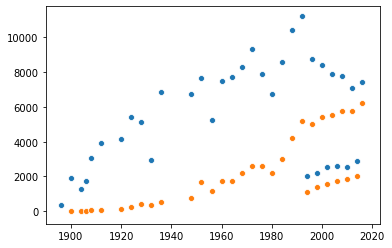

In [16]:
f_year_count = data[data.Sex=='F'].groupby('Year').agg('count').Name
m_year_count = data[data.Sex=='M'].groupby('Year').agg('count').Name
(sns.scatterplot(data= m_year_count),
 sns.scatterplot(data =f_year_count))

# Feature engineering

We choose to use external datasets to enrich the analyse and build novel feature sets. 

In this section most of the code is wrapped around unit tests to ensure the transformation have been carried out as expected.

## Mapping host cities to host countries

Firstly, we create a map of Host Cities to Host Country, which wasn't originally in the dataset. This will be when looking at the 'Home-advantage' hypothesis.

In [17]:
#manually created a dictionary map from city -> country 
city_to_country = { 'Barcelona':'Spain', 'London':'UK', 'Antwerpen':'Belgium', 'Paris':'France', 'Calgary':'Canada',
       'Albertville':'France', 'Lillehammer':'Norway', 'Los Angeles':'USA', 'Salt Lake City':'USA',
       'Helsinki':'Finland', 'Lake Placid':'USA', 'Sydney':'Australia', 'Atlanta':'USA', 'Stockholm':'Sweden',
       'Sochi':'Russia', 'Nagano':'Japan', 'Torino':'Italy', 'Beijing':'China', 'Rio de Janeiro':'Brazil', 'Athina':'Greece',
       'Squaw Valley':'USA', 'Innsbruck':'Austria', 'Sarajevo': 'Bosnia and Herzegovina', 'Mexico City':'Mexico', 'Munich': 'Germany',
       'Seoul': 'South Korea', 'Berlin': 'Germany', 'Oslo': 'Norway', "Cortina d'Ampezzo":'Italy', 'Melbourne': 'Australia', 'Roma': 'Italy',
       'Amsterdam': 'Netherlands', 'Montreal': 'Canada', 'Moskva': 'Russia', 'Tokyo':'Japan', 'Vancouver':'Canada', 'Grenoble':'France',
       'Sapporo':'Japan', 'Chamonix':'France', 'St. Louis':'USA', 'Sankt Moritz':'Switzerland',
       'Garmisch-Partenkirchen':'Germany'}

#simple dictionary map
def map_cities_to_countries(data, dict_city_to_country) : 
    data['Host_Country'] = data['City'].map(dict_city_to_country)
    return data

# unit test the mapping to ensure the merge did not introduce nulls into the dataset. 
class TestMapping(unittest.TestCase):
    # Create the unit test
    def test_mapping(self):
        map_cities_to_countries(data, city_to_country)
        count_na = data['Medal'].isnull().sum()
        
        # Test that the mapping has not introduces NA's
        self.assertEqual(0, count_na)
        
 # Run the test 
unittest.main(argv=['ignored', '-v'], exit=False)   

test_mapping (__main__.TestMapping) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.042s

OK


## Summary statistics to explore how athletes have changed over the years

In this question, i'm looking to explore how the sex, age, and number of competitors has changed in the last 120 years.


In [18]:
#Proportion
ProportionMvW = data.groupby(['Year', 'Sex']).agg({'Name': 'count'})

percentages = ProportionMvW.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
percentages = percentages.reset_index()
percentages[:3]

Year Sex        Name
0  1896   M  100.000000
1  1900   F    1.704545
2  1900   M   98.295455

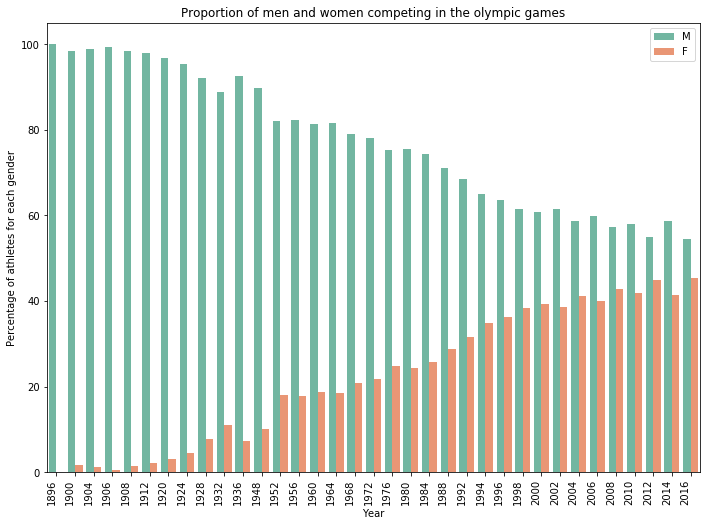

In [19]:
a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

ax = sns.barplot(x="Year", y="Name", hue="Sex", data=percentages, palette="Set2") 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
ax.set_title('Proportion of men and women competing in the olympic games')
ax.set_ylabel('Percentage of athletes for each gender')
ax.legend(loc="upper right")
plt.show()

### Insights:

Good news! The ratio of male to female competitors is slowly becoming more balanced - could 2020 be the year that we have an equal number of female competitors and male competitors?


The visualisation below shows how the distribution of men and women's ages have changed since 1896, split by Sex and Summer/Winter Olympics

In [20]:
cols_to_keep = ['Name', 'Sex', 'Age', 'Team', 'Height', 'Weight', 'Year', 'Season',
       'City', 'Sport', 'Event', 'Medal', 'region', 'Host_Country', 
                'CapitalName', 'ContinentName', 'vincenty_distance', 'HostAltitude']

clean_data = pd.DataFrame(data, columns=cols_to_keep)

# Rename the columns
clean_data.columns = ['Name', 'Sex', 'Age', 'Team', 'Height', 'Weight', 'Year', 'Season',
        'City', 'Sport', 'Event', 'Medal', 'AthleteCountry', 'HostCountry', 
        'AthletesHomeCapital', 'AthletesHomeContinent', 'DistanceTravelled', 'HostCityAltitude']

clean_data.head(3)

Name Sex   Age   Team  Height  Weight  Year  Season       City  \
0      A Dijiang   M  24.0  China   180.0    80.0  1992  Summer  Barcelona   
1       A Lamusi   M  23.0  China   170.0    60.0  2012  Summer     London   
2  Abudoureheman   M  22.0  China   182.0    75.0  2000  Summer     Sydney   

        Sport                         Event Medal AthleteCountry HostCountry  \
0  Basketball   Basketball Men's Basketball  None          China       Spain   
1        Judo  Judo Men's Extra-Lightweight  None          China          UK   
2      Boxing     Boxing Men's Middleweight  None          China   Australia   

   AthletesHomeCapital  AthletesHomeContinent  DistanceTravelled  \
0                  NaN                    NaN                NaN   
1                  NaN                    NaN                NaN   
2                  NaN                    NaN                NaN   

   HostCityAltitude  
0               NaN  
1               NaN  
2               NaN

## One-hot encode the Medal variable to make later analysis easier

In [21]:
df_medals = pd.get_dummies(clean_data['Medal'])

# Join the dummy variables to the main dataframe
clean_data = pd.concat([clean_data, df_medals], axis=1)
pd.options.display.max_columns = None
clean_data.head(3)

Name Sex   Age   Team  Height  Weight  Year  Season       City  \
0      A Dijiang   M  24.0  China   180.0    80.0  1992  Summer  Barcelona   
1       A Lamusi   M  23.0  China   170.0    60.0  2012  Summer     London   
2  Abudoureheman   M  22.0  China   182.0    75.0  2000  Summer     Sydney   

        Sport                         Event Medal AthleteCountry HostCountry  \
0  Basketball   Basketball Men's Basketball  None          China       Spain   
1        Judo  Judo Men's Extra-Lightweight  None          China          UK   
2      Boxing     Boxing Men's Middleweight  None          China   Australia   

   AthletesHomeCapital  AthletesHomeContinent  DistanceTravelled  \
0                  NaN                    NaN                NaN   
1                  NaN                    NaN                NaN   
2                  NaN                    NaN                NaN   

   HostCityAltitude  Bronze  Gold  None  Silver  
0               NaN       0     0     1       0  
1               NaN       0     0     1       0  
2               NaN       0     0     1       0

In [22]:
clean_data['TotalMedals'] = clean_data['Gold'] + clean_data['Silver'] + clean_data['Bronze']

clean_data['AnyMedals'] = np.where(clean_data.loc[:,'Medal'] == 'None', 0, 1)
clean_data.sample(2)

Name Sex   Age            Team  Height  Weight  Year  \
268352        Cheng Fu   M  22.0  Chinese Taipei   165.0    60.0  1968   
138634  William Morton   M  27.0          Canada     NaN     NaN  1908   

        Season         City       Sport                           Event Medal  \
268352  Summer  Mexico City  Gymnastics  Gymnastics Men's Parallel Bars  None   
138634  Summer       London     Cycling    Cycling Men's 100 kilometres  None   

       AthleteCountry HostCountry  AthletesHomeCapital  AthletesHomeContinent  \
268352         Taiwan      Mexico                  NaN                    NaN   
138634         Canada          UK                  NaN                    NaN   

        DistanceTravelled  HostCityAltitude  Bronze  Gold  None  Silver  \
268352                NaN               NaN       0     0     1       0   
138634                NaN               NaN       0     0     1       0   

        TotalMedals  AnyMedals  
268352            0          0  
138634            0          0

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


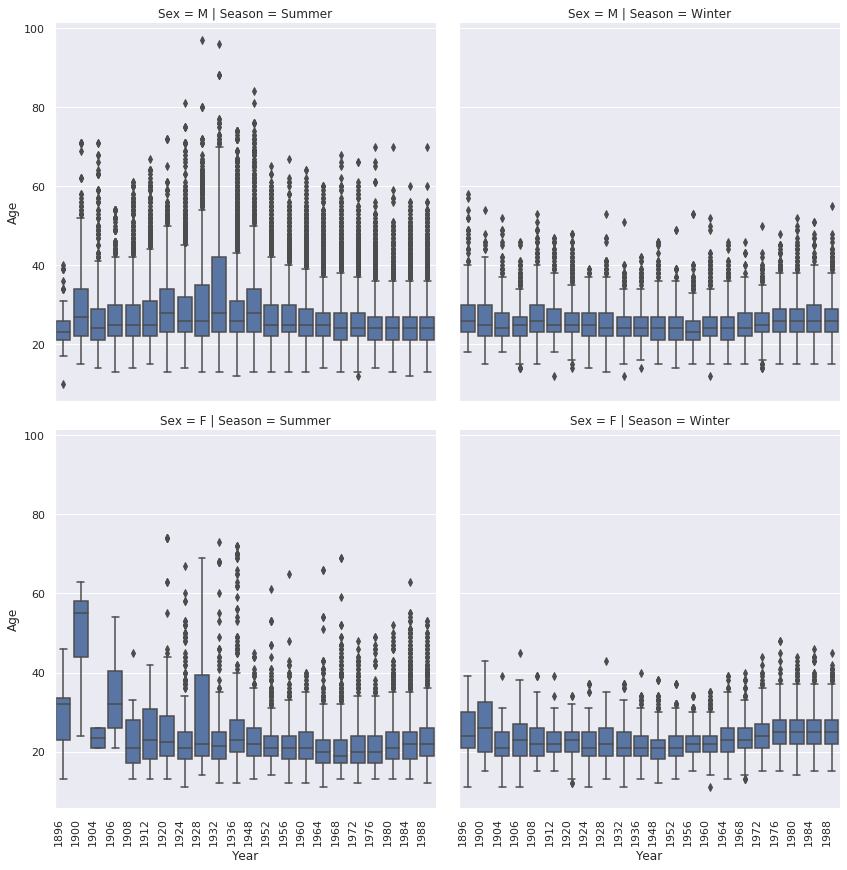

In [23]:
sns.set(rc={'figure.figsize':(20,20)})

g = sns.FacetGrid(clean_data, col="Season",  row="Sex", size=6)
g = g.map(sns.boxplot, "Year", 'Age')
g.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")

show()

Insights:

+ some 'athletes' in the 20th century were > 80 years when they competed! Worth a quick look back at the data to see what they competed in.

+ As could be expected, variance is greatly reduced in the modern athletes age (with the median Age being in the early 20's. Interestingly the median age in the winter olympics seems to be higher.
    
+ Higher variance in the Summer Olympics - I would hypothesise this is down to the wider variety of sports on offer at the Summer Olympics.



## Analysis of some interesting countries

In [24]:
#create a table of year,countryname & sex to be merged into a count of each later. 
mini_country_table = clean_data[clean_data['Season'] == 'Summer'].loc[:, ['Year','AthleteCountry', 'Name', 'Sex']].drop_duplicates()
mini_country_table.head(3)

Year AthleteCountry           Name Sex
0  1992          China      A Dijiang   M
1  2012          China       A Lamusi   M
2  2000          China  Abudoureheman   M

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs


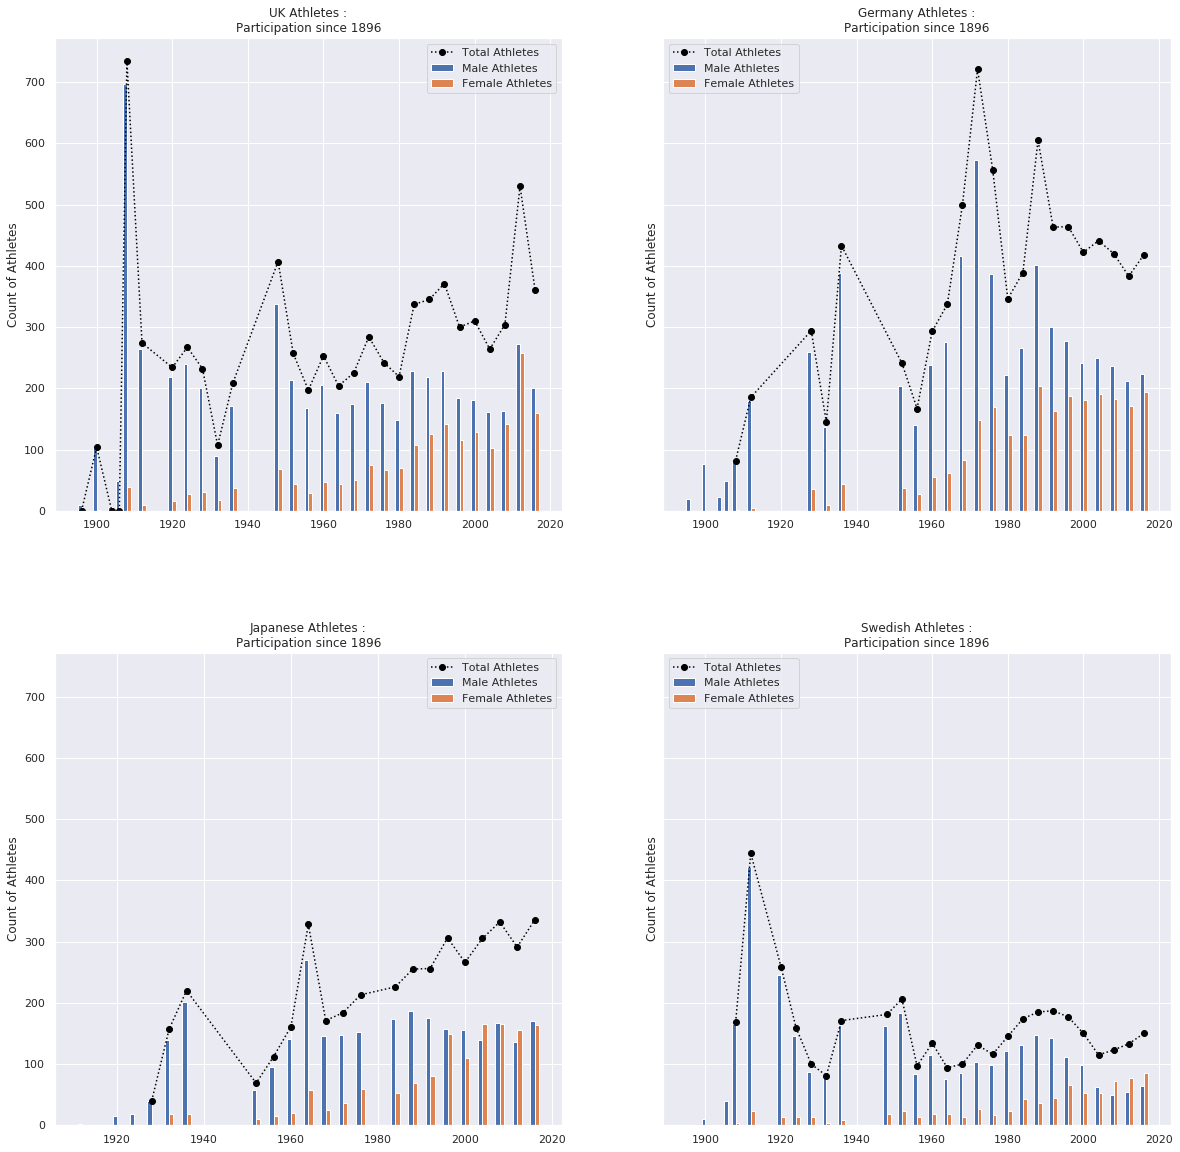

In [25]:
# Create a pivot table to count gender wise representation of each team in each year
CountAthletesByCountry = pd.pivot_table(mini_country_table,
                                        index = ['Year', 'AthleteCountry'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
CountAthletesByCountry.columns = CountAthletesByCountry.columns.get_level_values(0)

# rename the columns appropriately
CountAthletesByCountry.columns = ['Year', 'AthleteCountry', 'Female_Athletes', 'Male_Athletes']

# get total athletes per team-year
CountAthletesByCountry['Total_Athletes'] = CountAthletesByCountry['Female_Athletes'] + \
CountAthletesByCountry['Male_Athletes']

uk_athletes = CountAthletesByCountry[CountAthletesByCountry['AthleteCountry'] == "United Kingdom"]
uk_athletes.fillna(0, inplace = True)
uk_athletes.set_index('Year', inplace = True)

swedish_athletes = CountAthletesByCountry[CountAthletesByCountry['AthleteCountry'] == "Sweden"]
swedish_athletes.set_index('Year', inplace = True)

japanese_athletes = CountAthletesByCountry[CountAthletesByCountry['AthleteCountry'] == "Japan"]
japanese_athletes.set_index('Year', inplace = True)

germany_athletes = CountAthletesByCountry[CountAthletesByCountry['AthleteCountry'] == "Germany"]
germany_athletes.set_index('Year', inplace = True)

# Plot the values of male, female and total athletes using bar charts and the line charts.
fig, ((ax1, ax2), (ax3, ax4)) = subplots(nrows = 2, ncols = 2, figsize = (20, 20), sharey = True)
fig.subplots_adjust(hspace = 0.3)

# Plot team Australia's contingent size
ax1.bar(uk_athletes.index.values, uk_athletes['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax1.bar(uk_athletes.index.values, uk_athletes['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax1.plot(uk_athletes.index.values, uk_athletes['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax1.legend(loc="upper right")
ax1.set_title('UK Athletes :\nParticipation since 1896')
ax1.set_ylabel('Count of Athletes')

# Plot German athlete participation
ax2.bar(germany_athletes.index.values, germany_athletes['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax2.bar(germany_athletes.index.values, germany_athletes['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax2.plot(germany_athletes.index.values, germany_athletes['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax2.set_title('Germany Athletes :\nParticipation since 1896')
ax2.legend(loc="upper left")

ax2.set_ylabel('Count of Athletes')

# Plot Japan's contingent size
ax3.bar(japanese_athletes.index.values, japanese_athletes['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax3.bar(japanese_athletes.index.values, japanese_athletes['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax3.plot(japanese_athletes.index.values, japanese_athletes['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes', 
         marker = 'o')
ax3.set_title('Japanese Athletes :\nParticipation since 1896')
ax3.set_ylabel('Count of Athletes')
ax3.legend(loc="upper right")


# Plot team Swedens's contingent size
ax4.bar(swedish_athletes.index.values, swedish_athletes['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax4.bar(swedish_athletes.index.values, swedish_athletes['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax4.plot(swedish_athletes.index.values, swedish_athletes['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax4.set_title('Swedish Athletes :\nParticipation since 1896')
ax4.set_ylabel('Count of Athletes')
ax4.legend(loc="upper left")

show()

# Conclusions and further research options

After above analysis and do some unittests, we could figure out the following insights:

+ To understand the balance of gender 

+ High variance in the early years (slightly higher median age for the Winter Olympics)

+ Focusing to the study in (UK, Germany, Sweden & Japan), Germany send the most athletes (on average each year),
